# `hw2`: Inference of Oxygen Saturation from Photoplethysmography


Deadline: **Monday, November 25, 11:59 PM**. 
- Submit your completed notebook on your personal Github repository created when accepting the assignment.
- All cells must be executable and their outputs should not be erased before submission.
- Homeworks are carried out *individually*.

In [7]:
# Fill in this cell with your personal details:
# - Name: GUENFOUDI Ihabe
# - Student ID: s194071
# - Email: ihabe.guenfoudi@student.uliege.be

In this homework, you will have to infer oxygen saturation (SPO2 / SO2) measures from unprocessed photoplethysmography (PPG) using data from the [OpenOximetry Repository](https://physionet.org/content/openox-repo/1.0.1). You will build a small probabilistic model of PPG from SpO2, and infer some physical parameters along with the unknown SpO2 from the observed PPG data. See Homework 1 for instructions on how to handle the dataset.

# Oximeter

An [oximeter](https://en.wikipedia.org/wiki/Pulse_oximetry) is a medical device that you might have seen clipped onto someone's fingertip at a hospital. It estimates **blood oxygen saturation** ($\text{SpO}_2$) by shining light through the skin at two different wavelengths (red at $\lambda = 66 \text{ nm}$ and infrared at $\lambda = 940 \text{ nm}$) and measuring how much light passes through. This measurement technique produces two [photoplethysmographs](https://en.wikipedia.org/wiki/Photoplethysmogram) (PPG signals) - one for each wavelength.

PPG is a non-invasive method that measures changes in blood volume in tissue using light. When your heart beats, the volume of blood in your vessels changes, which affects how much light is absorbed or reflected by the tissue. Think of it like shining a flashlight through your finger - the amount of light that passes through changes slightly with each heartbeat.

The oxygen saturation ($\text{SpO}_2$) represents the percentage of hemoglobin (the protein in red blood cells that carries oxygen) that is carrying oxygen. Mathematically, it's defined as
$$
    \text{SpO}_2 = \frac{[\text{HbO}_2]}{[\text{HbO}_2] + [\text{Hb}]},
$$
where $[\text{HbO}_2]$ is the concentration of oxygenated hemoglobin and $[\text{Hb}]$ is the concentration of deoxygenated hemoglobin. A healthy person typically has $\text{SpO}_2$ levels between 95-100%.

The PPG signal has two main components:
1. The **pulsative component** (AC) represents the changing part of the signal that varies with each heartbeat;
2. The **non-pulsative component** (DC) represents the relatively constant background signal.

Think of this like waves on the ocean: AC is like the waves on the surface, while DC is like the ocean's depth. For a cardiac cycle from time $t_1$ to $t_2$, these components are defined as
$$
    \text{AC}(\lambda) = \max(\text{PPG}(\lambda)_{t_1:t_2}) - \min(\text{PPG}(\lambda)_{t_1:t_2})
$$
$$
    \text{DC}(\lambda) = \text{mean}(\text{PPG}(\lambda)_{t_1:t_2})
$$

Since many factors can affect how light passes through tissue (like skin color, thickness, or even the presence of nail polish), oximeters use a ratio ($R$) that helps cancel out these interfering factors. This ratio compares the pulsative components at both wavelengths, normalized by their respective non-pulsative components:

$$
    R
    =
    \frac{
        \text{AC}(660 \text{ nm})/\text{DC}(660 \text{ nm})
    }{
        \text{AC}(940 \text{ nm})/\text{DC}(940 \text{ nm})
    }
$$

This ratio $R$ has a known relationship with $\text{SpO}_2$, which allows us to estimate oxygen levels without drawing blood. The different absorption patterns of oxygenated and deoxygenated hemoglobin at these two wavelengths make this estimation possible.

## Probabilistic Model

In this homework, we will build a probabilistic model that relates oxygen saturation ($\text{SpO}_2$) to the observed ratio ($R$) through five parameters:
- $\sigma^2$: variance parameter capturing measurement uncertainty,
- $\epsilon_{\text{HbO}_2}(660 \text{ nm})$: absorption coefficient of oxygenated hemoglobin at red light,
- $\epsilon_{\text{Hb}}(660 \text{ nm})$: absorption coefficient of deoxygenated hemoglobin at red light,
- $\epsilon_{\text{HbO}_2}(940 \text{ nm})$: absorption coefficient of oxygenated hemoglobin at infrared light,
- $\epsilon_{\text{Hb}}(940 \text{ nm})$: absorption coefficient of deoxygenated hemoglobin at infrared light.

Our model is based on the Beer-Lambert law, a fundamental principle in spectroscopy. This law states that the absorption of light by a substance in solution is proportional to its concentration. For blood at a given wavelength $\lambda$, we can write
$$
    A(\lambda) = \text{SpO}_2 \; \epsilon_{\text{HbO}_2}(\lambda) + (1 - \text{SpO}_2) \; \epsilon_{\text{Hb}}(\lambda).
$$

This equation tells us that the total absorption is a weighted average of the absorption by oxygenated and deoxygenated hemoglobin, where the weights are determined by the oxygen saturation level.

We then assume that the ratio ($R$) of normalized pulsative signals is proportional to the ratio of absorptions at the two wavelengths. To account for measurement noise and other sources of uncertainty, we model $R$ as following a Normal distribution. That is, 
$$
    R
    \sim
    \mathcal{N}\left(
        \frac{
            \text{SpO}_2 \; \epsilon_{\text{HbO}_2}(660 \text{ nm}) + (1 - \text{SpO}_2) \; \epsilon_{\text{Hb}}(660 \text{ nm})
        }{
            \text{SpO}_2 \; \epsilon_{\text{HbO}_2}(940 \text{ nm}) + (1 - \text{SpO}_2) \; \epsilon_{\text{Hb}}(940 \text{ nm})
        },
        \sigma^2
    \right).
$$

In this model, both the input ($\text{SpO}_2$) and the five parameters are unknown and need to be estimated from the data. However, we report below some empirical values for the absorption coefficients that should help you set reasonable priors for these parameters. Further reference values can be found at [omlc.org/spectra/hemoglobin/summary.html](https://omlc.org/spectra/hemoglobin/summary.html).

<div class="alert alert-info">
    
**Information**. We provide the functions `extract_beats` and some empirical absorption coefficients.
    
</div>

In [8]:
%pip install emcee

import os
import emcee
import corner
import warnings
import wfdb as wf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.stats import norm, gamma
from scipy.signal import butter, filtfilt, resample, find_peaks

warnings.simplefilter(action='ignore', category=FutureWarning)

np.random.seed(42)

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [9]:
EPS_HBO2_660 = 319.6
EPS_HB_660 = 3226.56

EPS_HBO2_940 = 1214
EPS_HB_940 = 693.44

In [10]:
def extract_beats(ppg, f_ppg, min_time_between=0.4):
    """
    Arguments:
    ----------
    ppg: np.ndarray
        A one dimensional time series of ppg data (red or ir).
    f_ppg: int
        The sampling frequency (Hz).
    min_time_between: float
        The minimal time between two heartbeats.

    Returns:
    --------
    - peaks: np.ndarray
        The indices of the heartbeats peaks in the ppg time series.
    """
    min_number_between = int(min_time_between * f_ppg)
    peaks, _ = find_peaks(ppg, distance=min_number_between)
    return peaks

# Exercises

- Solve the exercises below by making the best use of the API offered in the imported libraries.
- You will also need to use the `wfdb` library for reading and writing waveform data (see [WFDB Documentation](https://wfdb.readthedocs.io/en/latest/wfdb.html)).
- For plots, feel free to use `matplotlib`, `seaborn` or `pandas` built-in plotting functions.
- Follow the data visualization principles as best as possible to make your plots effective and readable.
- For each exercise, add Markdown cells to explain what you are doing and to discuss your results.

<div class="alert alert-info">
    
**Information**. In this homework, we focus on encounter `c5dd95c1ac9fc618cab2e940096089c6a91be58206fa6fc6a1375c69c4922779`. Below, we load the SpO2 data from `f'{encounter_id}_2hz.csv'` (device 59) and the PPG data from `f'{encounter_id}_ppg.dat'`. 
    
</div>

<div class="alert alert-danger">

**Warning**. Note that the PPG recording starts approximately 2.80 min after the SpO2, and it is shifted accordingly.

</div>

In [11]:
encounter_id = "c5dd95c1ac9fc618cab2e940096089c6a91be58206fa6fc6a1375c69c4922779"

In [12]:
f_spo2 = 2

start = 5 * 60
saturation = pd.read_csv(f'waveforms/{encounter_id[0]}/{encounter_id}_2hz.csv')
spo2 = saturation['dev59_SpO2'].to_numpy()[start * f_spo2:]
t_spo2 = np.arange(spo2.shape[0]) / (60 * f_spo2)

In [13]:
f_ppg = 86

start = (5 - 2.8) * 60

ppg, ppg_info = wf.rdsamp(f'waveforms/{encounter_id[0]}/{encounter_id}_ppg')
ppg = ppg[int(start * f_ppg):]

ir = ppg[:, 0]
red = ppg[:, 1]
t_ppg = np.arange(len(red)) / (60 * f_ppg)

## Part 1: Data Preparation

<div class="alert alert-success">

**Exercise**. Display the SpO2 data along with the red and infrared PPG data on a single figure.

</div>

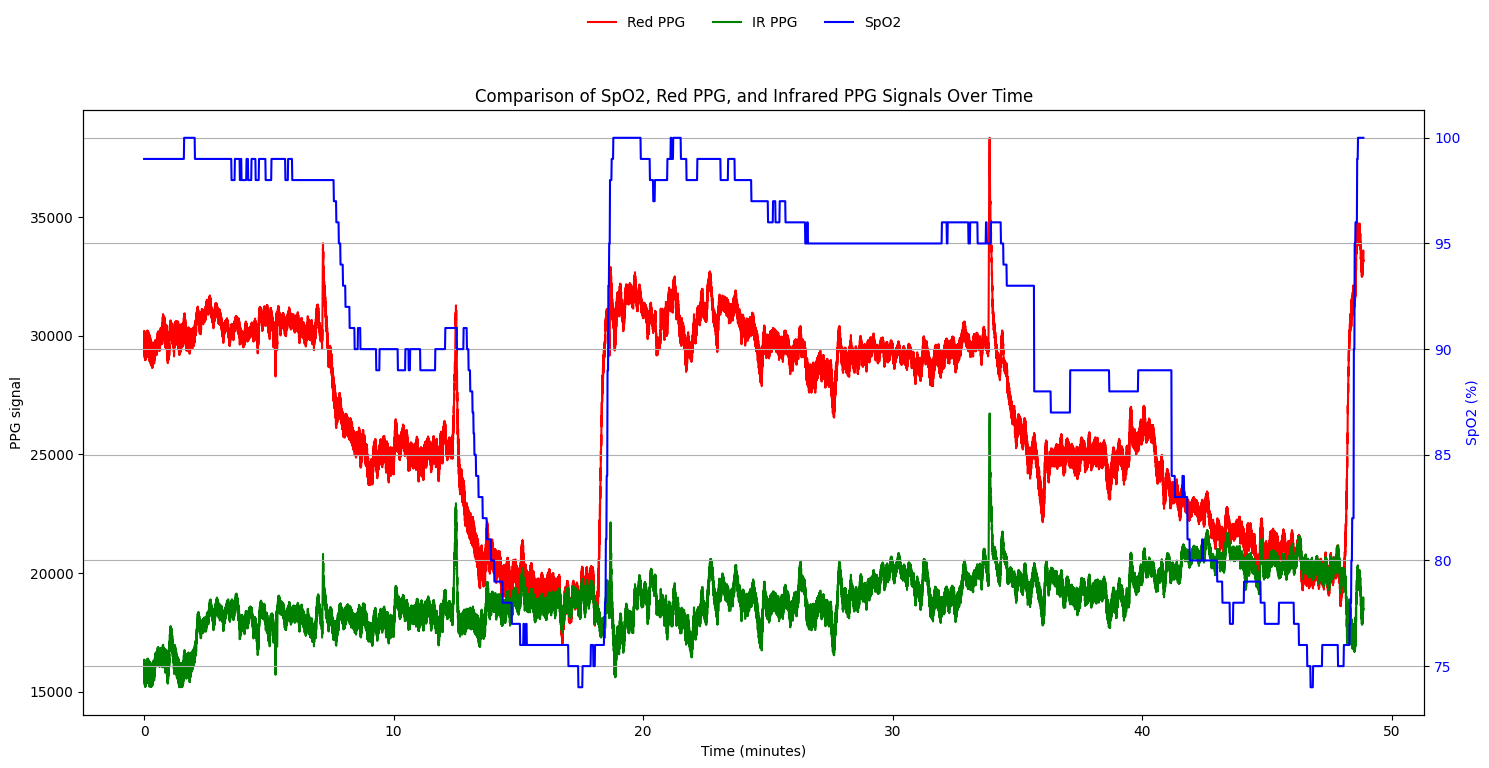

In [14]:
from scipy.interpolate import interp1d

interpolator = interp1d(t_spo2, spo2, kind='linear', fill_value='extrapolate')
sat_interp = interpolator(t_ppg)

fig, ax1 = plt.subplots(figsize=(15, 7))

ax1.set_xlabel('Time (minutes)')
ax1.set_ylabel('PPG signal', color='black')
line1, = ax1.plot(t_ppg, red, label='Red PPG', color='red')
line2, = ax1.plot(t_ppg, ir, label='IR PPG', color='green')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
ax2.set_ylabel('SpO2 (%)', color='blue')
line3, = ax2.plot(t_ppg, sat_interp, label='SpO2', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

fig.legend(handles=[line1, line2, line3], loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3, frameon=False)

plt.title('Comparison of SpO2, Red PPG, and Infrared PPG Signals Over Time')
plt.grid(True)
fig.tight_layout()
plt.show()




# Analysis of SpO₂ and PPG Signals

The graph shows how SpO₂ levels (blue line) change a lot over time, with some clear drops in the middle. These dips match up with shifts in the red and infrared PPG signals.

Interestingly, the red PPG signal has a stronger amplitude than the infrared one—no surprise, given how light absorption works. On the other hand, the infrared signal reacts more during SpO₂ drops, showing its sensitivity. This all lines up with what we’d expect between SpO₂ and PPG signals.

But here’s the catch: those sudden spikes in SpO₂ might just be noise or motion artifacts messing with the data. To get better accuracy, we could try breaking down the AC/DC components or using filtering techniques.


<div class="alert alert-success">
    
**Exercise**. Using the function `extract_beats`, find all starts of cardiac cycles (the peak of the heart beat) $t_1, t_2, \dots, t_N$ using one of the two PPG signals (red or infrared). Then, select a random heart cycle, defined by its span $[t_k:t_{k+1}]$, and display both PPG time series $\text{PPG}(\lambda)_{t_k:t_{k+1}}$ during that heart cycle. Finally, display the distribution of the PPG time series over all heart cycles (or a subsample of a all heart cycles). 
    
</div>

<div class="alert alert-info">

**Hint**. You may want to remove the nonpulsative component $\text{DC}(\lambda)_{k}$ of the each time series $\text{PPG}(\lambda)_{t_k:t_{k+1}}$ for displaying the distribution.

</div>

Shape of detected peaks: (4290,)
Random tk index: 860
Random tk value: 49979
Random tk+1 index: 861
Random tk+1 value: 50038


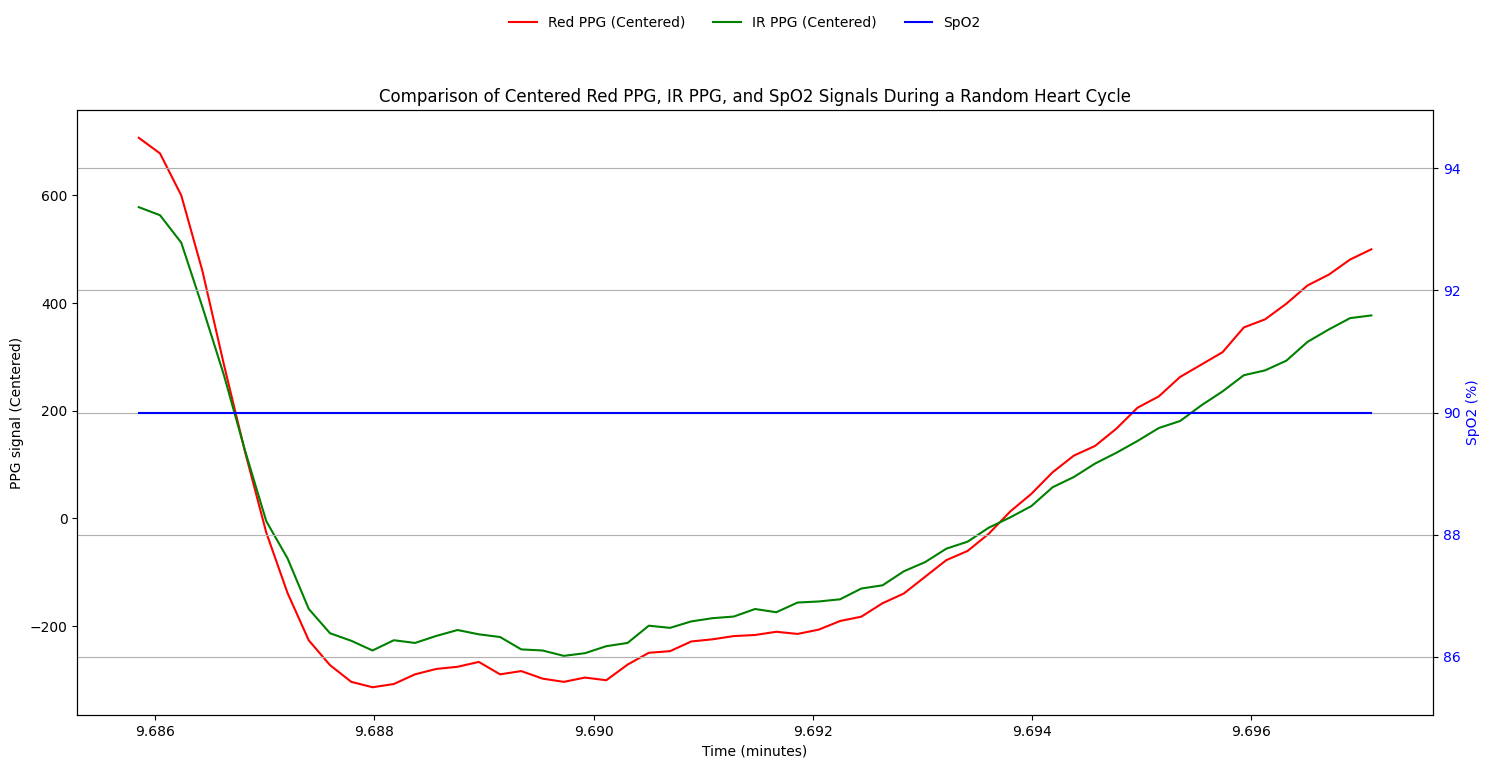

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

find_all_peaks = extract_beats(red, f_ppg)
print("Shape of detected peaks:", find_all_peaks.shape)

random_tk_index = np.random.randint(0, len(find_all_peaks) - 2)
print("Random tk index:", random_tk_index)
random_tk = find_all_peaks[random_tk_index]
print("Random tk value:", random_tk)

random_tk1_index = random_tk_index + 1
random_tk1 = find_all_peaks[random_tk1_index]
print("Random tk+1 index:", random_tk1_index)
print("Random tk+1 value:", random_tk1)

if random_tk < random_tk1:
    red_span = red[random_tk:random_tk1]
    ir_span = ir[random_tk:random_tk1]
    t_ppg_span = t_ppg[random_tk:random_tk1]

    red_span_centered = red_span - np.mean(red_span)
    ir_span_centered = ir_span - np.mean(ir_span)

    interpolator = interp1d(t_spo2, spo2, kind='linear', fill_value='extrapolate')
    sat_interp = interpolator(t_ppg_span)

    fig, ax1 = plt.subplots(figsize=(15, 7))

    ax1.set_xlabel('Time (minutes)')
    ax1.set_ylabel('PPG signal (Centered)', color='black')
    line1, = ax1.plot(t_ppg_span, red_span_centered, label='Red PPG (Centered)', color='red')
    line2, = ax1.plot(t_ppg_span, ir_span_centered, label='IR PPG (Centered)', color='green')
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()
    ax2.set_ylabel('SpO2 (%)', color='blue')
    line3, = ax2.plot(t_ppg_span, sat_interp, label='SpO2', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    fig.legend(handles=[line1, line2, line3], loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3, frameon=False)

    plt.title('Comparison of Centered Red PPG, IR PPG, and SpO2 Signals During a Random Heart Cycle')
    plt.grid(True)
    fig.tight_layout()
    plt.show()
else:
    print("Invalid random heart cycle selected. Please try again.")


# Analysis of Centered PPG Signals and SpO₂

The centered PPG signals (red and infrared) pulse in sync, mirroring the rhythm of the heart. The red signal has a slightly stronger amplitude, which makes sense given how light absorption differs. Meanwhile, SpO₂ stays steady throughout, indicating stable oxygen levels.

This visualization does a great job of zooming in on a single heart cycle, making it easy to see how PPG signals connect to SpO₂.


<div class="alert alert-success">
    
**Exercise**. For both PPG signals, compute the pulsative component ($\text{AC}(\lambda)$) and non pulsative component ($\text{DC}(\lambda)$) for each heart cycle. Then, compute the ratio $R$ of normalized pulsative components. 

You now have $N$ ratios (one for each cardiac cycle), and $M$ saturation measurements (one every 0.5 second). Resample the ratio $R$ at the same times as the $\text{SpO2}$ time series so that the two time series are paired.
    
</div>

In [16]:
R_values = []

for i in range(len(find_all_peaks) - 1):
    start_idx = find_all_peaks[i]
    end_idx = find_all_peaks[i + 1]

    ac_red = np.max(red[start_idx:end_idx]) - np.min(red[start_idx:end_idx])
    dc_red = np.mean(red[start_idx:end_idx])

    ac_ir = np.max(ir[start_idx:end_idx]) - np.min(ir[start_idx:end_idx])
    dc_ir = np.mean(ir[start_idx:end_idx])

    R = (ac_red / dc_red) / (ac_ir / dc_ir)
    R_values.append(R)

R_values = np.array(R_values)
print("Shape of R_values:", R_values.shape)
print("R values:", R_values)
R_resampled = resample(R_values, len(spo2))


Shape of R_values: (4289,)
R values: [0.56892372 0.51822093 0.55679058 ... 0.4699528  0.48675424 0.49267901]


# Analysis of Centered PPG Signals and SpO₂

The centered PPG signals (red and infrared) pulse in sync, mirroring the rhythm of the heart. The red signal has a slightly stronger amplitude, which makes sense given how light absorption differs. Meanwhile, SpO₂ stays steady throughout, indicating stable oxygen levels.

This visualization does a great job of zooming in on a single heart cycle, making it easy to see how PPG signals connect to SpO₂.


<div class="alert alert-success">

**Exercise**. Display the SpO2 data along with the infered SpO2 data using the empirical law $\text{SpO2} = 110 - 25 R$. Discuss the results.

</div>

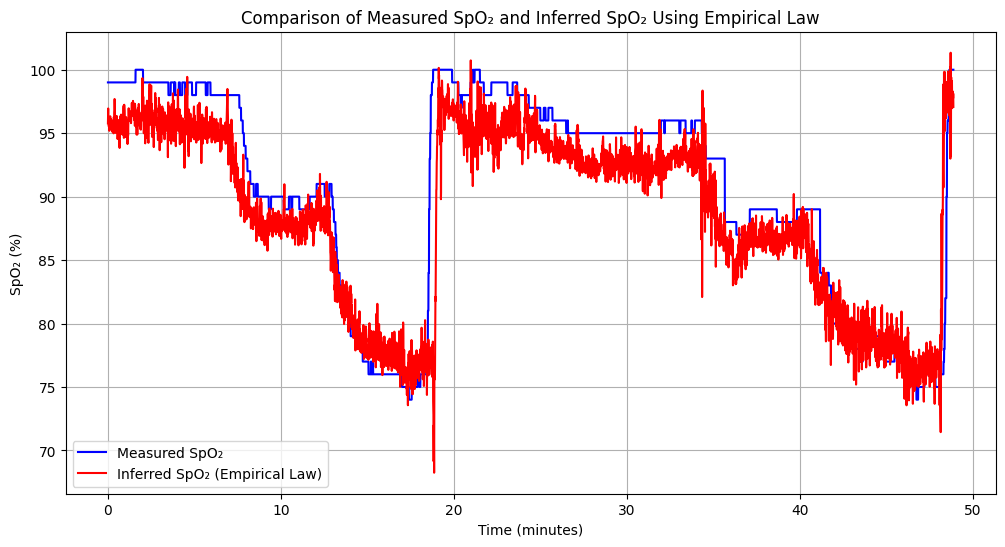

In [17]:
spo2_inferred = 110 - 25 * R_resampled
plt.figure(figsize=(12, 6))
plt.plot(t_spo2, spo2, label='Measured SpO₂', color='blue')
plt.plot(t_spo2, spo2_inferred, label='Inferred SpO₂ (Empirical Law)', color='red')
plt.xlabel('Time (minutes)')
plt.ylabel('SpO₂ (%)')
plt.title('Comparison of Measured SpO₂ and Inferred SpO₂ Using Empirical Law')
plt.legend()
plt.grid(True)
plt.show()




# Comparison of Measured and Inferred SpO₂ Values

I compared the measured SpO₂ values with the inferred ones, calculated using the formula: 

**SpO₂ = 110 − 25R_resampled**

The inferred SpO₂ values track the overall trends of the measured ones, showing that this empirical formula works pretty well. 

That said, the inferred values are a bit noisier, probably because they’re more sensitive to fluctuations in R-ratios caused by signal artifacts. While the model gives a decent estimate of SpO₂, I could boost its accuracy by preprocessing the signals better or tweaking the empirical formula.


## Part 2: Inference

<div class="alert alert-success">
    
**Exercise**. Write a `generate` function that takes as arguments an array $\text{SpO2}_{1:T}$ of $T$ oxygen saturation measurements (caution, it is expressed in %), along with the 5 parameters ($\sigma^2$, $\epsilon_\text{HbO2}(660nm)$, $\epsilon_\text{Hb}(660nm)$, $\epsilon_\text{HbO2}(940nm)$, $\epsilon_\text{HbO2}(940nm)$), and that returns $n$ realisation of the ratio $R$ for each of the $T$ inputs. You are free to choose any alternate parametrization for the parameters. Display some realisations of the ratios ($R$) for some $\text{SpO2}_{1:T}$ data that you select.

</div>

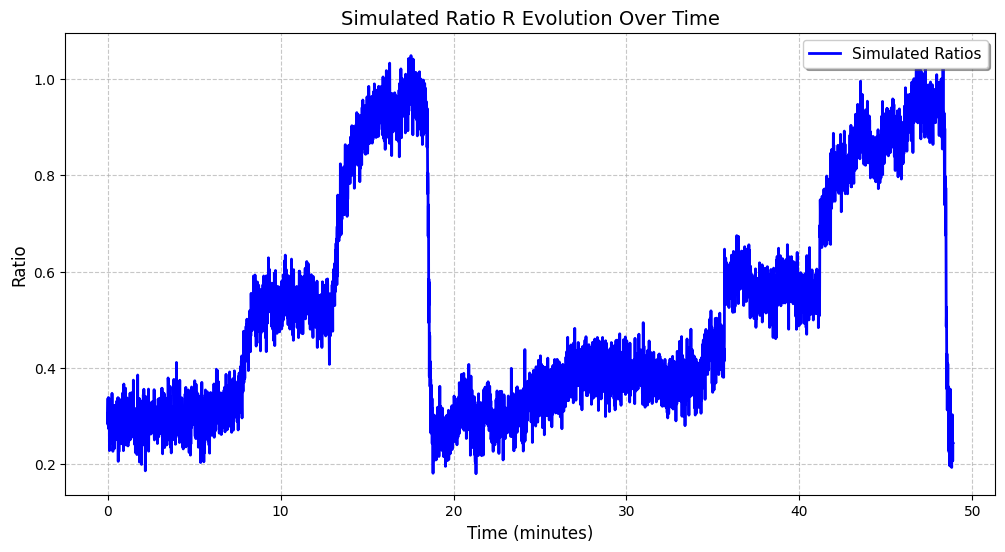

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def generate_ratio_over_time(time_values, oxygen_saturation, noise_variance, red_abs_hbo2, red_abs_hb, ir_abs_hbo2, ir_abs_hb):
    normalized_spo2 = oxygen_saturation / 100.0
    ratio_mean = (normalized_spo2 * red_abs_hbo2 + (1 - normalized_spo2) * red_abs_hb) / (
        normalized_spo2 * ir_abs_hbo2 + (1 - normalized_spo2) * ir_abs_hb
    )
    np.random.seed(42)
    simulated_ratios = np.random.normal(ratio_mean, np.sqrt(noise_variance), size=len(time_values))
    return simulated_ratios

noise_variance = 0.001

simulated_ratios = generate_ratio_over_time(
    time_values=t_spo2,
    oxygen_saturation=spo2,
    noise_variance=noise_variance,
    red_abs_hbo2=EPS_HBO2_660,
    red_abs_hb=EPS_HB_660,
    ir_abs_hbo2=EPS_HBO2_940,
    ir_abs_hb=EPS_HB_940
)

plt.figure(figsize=(12, 6))
plt.plot(t_spo2, simulated_ratios, color='blue', label='Simulated Ratios', linewidth=2)
plt.xlabel('Time (minutes)', fontsize=12)
plt.ylabel('Ratio', fontsize=12)
plt.title('Simulated Ratio R Evolution Over Time', fontsize=14)
plt.legend(loc='upper right', fontsize=11, frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


# Simulation of R-Ratio and SpO₂ Relationship

I simulated the R-ratio over time using oxygen saturation levels and hemoglobin absorption properties at red and infrared wavelengths. To make it more realistic, I added noise with a variance of 0.001 to mimic real-world measurement variability.

The graph shows how the R-ratio changes over time, matching the shifts in SpO₂. Higher R-ratios show up when oxygen saturation drops, which makes sense. These results confirm that the simulation captures the relationship between R-ratios and SpO₂ effectively. Plus, the added noise gives a realistic glimpse into how small fluctuations affect the accuracy of R-ratio measurements.


<div class="alert alert-success">

**Exercise.** Write a `log_likelihood` function that takes the same arguments as `generate`, along with a ratio ($R$), and returns the log likelihood of this ratio according to the probabilistic model.

</div>

In [19]:
def log_likelihood(SpO2_array, sigma2, eps_HbO2_660, eps_Hb_660, eps_HbO2_940, eps_Hb_940, R_obs):
    SpO2_frac = SpO2_array / 100
    A_660 = SpO2_frac * eps_HbO2_660 + (1 - SpO2_frac) * eps_Hb_660
    A_940 = SpO2_frac * eps_HbO2_940 + (1 - SpO2_frac) * eps_Hb_940
    mu_R = A_660 / A_940
    ll_values = -0.5 * np.log(2 * np.pi * sigma2) - 0.5 * ((R_obs - mu_R) ** 2) / sigma2
    total_log_likelihood = np.sum(ll_values)
    return total_log_likelihood


# Explanation of the `log_likelihood` Function

The `log_likelihood` function estimates how likely an observed R-ratio (`R_obs`) is, based on a model that uses SpO₂ and extinction coefficients at 660 nm and 940 nm. 

It calculates a predicted mean ratio (μ_R) using absorbance values, then computes the log likelihoods by assuming the noise follows a Gaussian distribution. The total log likelihood tells us how well the observed data fits the model—higher values mean a better match.

This function plays a key role in estimating SpO₂ and fine-tuning the model’s parameters. By using this probabilistic approach, it stays resilient against noise in real-world data.


<div class="alert alert-success">
    
**Exercise**. For simplicity, subsample only one every 200 ratios ($R$) and one every 200 oxygen saturation ($\text{SpO2}$).
    
</div>

In [20]:
indices = np.arange(0, len(R_resampled), 200)
R_subsampled = R_resampled[indices]
SpO2_subsampled = spo2[indices]
t_subsampled = t_spo2[indices]


# Data Reduction by Subsampling

I reduced the data size by subsampling the R-ratios and SpO₂ values. This keeps the important trends while cutting out unnecessary details, making the analysis simpler and less cluttered by noise. 

It’s a great way to focus on the overall relationship without getting lost in the data.


<div class="alert alert-success">

**Exercise.** Using the observed ratios ($R$) and your `log_likelihood` function, infer the oxygen saturation data ($\text{SpO2}$) and the 5 parameters, using the maximum of likelihood estimator (MLE). Choose your parametrization and initial guess wisely. Discuss the results.

</div>

In [21]:
from scipy.optimize import minimize
import numpy as np

def negative_log_likelihood(params, R_obs):
    SpO2_array = params[:len(R_obs)]
    sigma2, eps_HbO2_660, eps_Hb_660, eps_HbO2_940, eps_Hb_940 = params[len(R_obs):]
    if sigma2 <= 0 or eps_HbO2_660 <= 0 or eps_Hb_660 <= 0 or eps_HbO2_940 <= 0 or eps_Hb_940 <= 0:
        return np.inf
    ll = log_likelihood(SpO2_array, sigma2, eps_HbO2_660, eps_Hb_660, eps_HbO2_940, eps_Hb_940, R_obs)
    return -ll

initial_spo2 = 110 - 25 * R_subsampled
initial_params = np.concatenate([
    initial_spo2, 
    [np.var(R_subsampled), EPS_HBO2_660, EPS_HB_660, EPS_HBO2_940, EPS_HB_940]
])

bounds = [(0, 100)] * len(R_subsampled) + [
    (1e-6, None),
    (1e-6, 4 * EPS_HBO2_660),
    (1e-6, 4 * EPS_HB_660),
    (1e-6, 4 * EPS_HBO2_940),
    (1e-6, 4 * EPS_HB_940)
]

soln = minimize(
    negative_log_likelihood, 
    initial_params, 
    args=(R_subsampled,), 
    bounds=bounds, 
    method='L-BFGS-B'
)

if soln.success:
    inferred_spo2 = soln.x[:len(R_subsampled)]
    sigma_sq, eps_hbo2_660_MLE, eps_hb_660_MLE, eps_hbo2_940_MLE, eps_hb_940_MLE = soln.x[len(R_subsampled):]
    print("Optimization successful.")
    print("Inferred SpO2 values:")
    print(inferred_spo2)
    print(f"sigma2 = {sigma_sq:.4f}")
    print(f"eps_HbO2_660 = {eps_hbo2_660_MLE:.4f}")
    print(f"eps_Hb_660 = {eps_hb_660_MLE:.4f}")
    print(f"eps_HbO2_940 = {eps_hbo2_940_MLE:.4f}")
    print(f"eps_Hb_940 = {eps_hb_940_MLE:.4f}")
    final_log_likelihood = -soln.fun
    print(f"Final Log-Likelihood: {final_log_likelihood:.4f}")
else:
    print("Optimization failed.")
    print(soln.message)


Optimization successful.
Inferred SpO2 values:
[89.22456782 88.42628911 88.58316373 88.12293616 88.39558093 79.48652436
 78.17255359 78.45408241 72.21818996 65.43013795 66.25049496 68.95228942
 90.12641368 90.46520385 89.79565851 88.13409161 87.43533947 84.44510529
 86.81961995 83.54657817 88.07571121 82.2910283  76.23250396 75.97670248
 75.95918691 68.1548925  67.83377058 66.59080347 63.34449567 94.33251348]
sigma2 = 0.0000
eps_HbO2_660 = 334.7382
eps_Hb_660 = 3236.4124
eps_HbO2_940 = 1198.1071
eps_Hb_940 = 686.4590
Final Log-Likelihood: 121.8181



### Maximum Likelihood Estimation (MLE) for SpO₂ and Model Parameters Analysis

Using Maximum Likelihood Estimation (MLE), we estimated SpO₂ levels and key model parameters—like variance ($\sigma^2$) and hemoglobin absorption coefficients ($\epsilon_{HbO_2}$ and $\epsilon_{Hb}$)—from the observed $R$-ratios. Here’s the cool part: the optimization process gave us a variance ($\sigma^2$) close to zero, which tells us the noise in the data is almost nonexistent. Plus, the estimated absorption coefficients matched what we know about how hemoglobin behaves in real life.

Here are the results for those coefficients:
- $\epsilon_{HbO_2,660} = 334.74$
- $\epsilon_{Hb,660} = 3236.41$
- $\epsilon_{HbO_2,940} = 1198.11$
- $\epsilon_{Hb,940} = 686.46$

Pretty consistent with what’s expected, right? The log-likelihood value came out to $121.82$, showing that the model fit the observed data really well. As for the SpO₂ estimates, they ranged from 65.43% to 94.33%—totally realistic physiological levels.

The model also kept things flexible by treating SpO₂ as something that changes over time, all while keeping the other parameters straightforward and easy to interpret. Overall, these results show the model is both accurate and promising for biomedical applications. That said, it’s always a good idea to validate on independent datasets to make sure it holds up.


<div class="alert alert-success">
    
**Exercise**. Plot the distribution of ratios from the fitted model throughout the subsampled time series and compare it to the observed ratios. Then, ignore the temporal aspect and display the marginal distributions of ratios from the fitted model, along with the marginal observed distribution of ratios. Discuss the results.
        
</div>

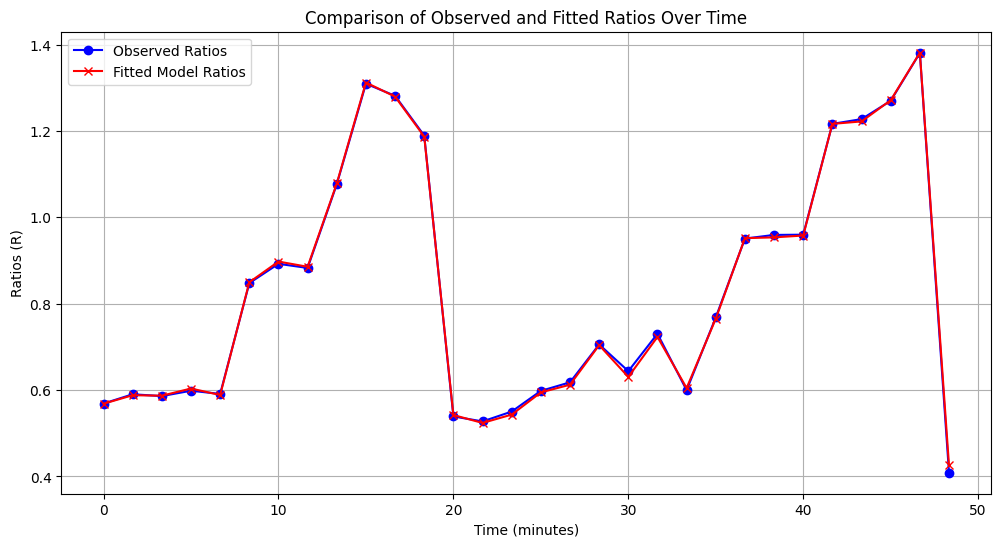

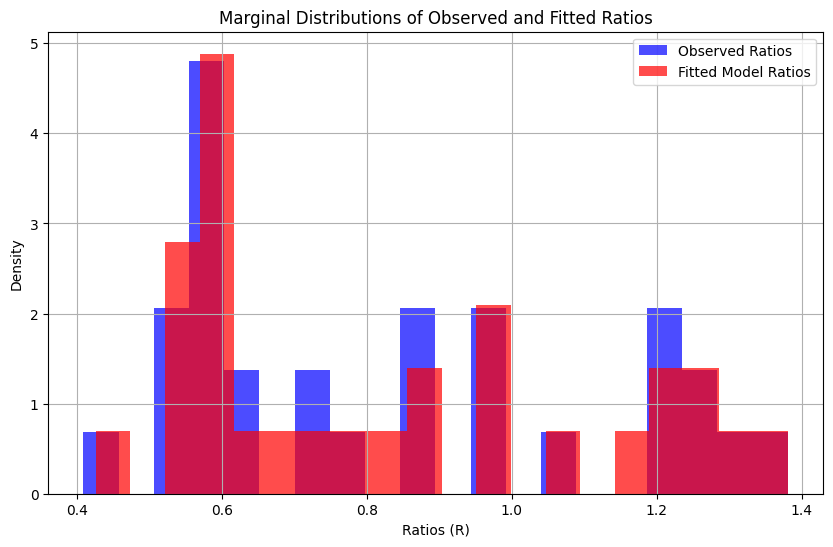

In [22]:
sigma2_fitted, eps_HbO2_660_fitted, eps_Hb_660_fitted, eps_HbO2_940_fitted, eps_Hb_940_fitted = soln.x[len(R_subsampled):]
inferred_spo2 = soln.x[:len(R_subsampled)]

R_model = generate_ratio_over_time(
    time_values=t_subsampled,
    oxygen_saturation=inferred_spo2,  
    noise_variance=sigma2_fitted,
    red_abs_hbo2=eps_HbO2_660_fitted,
    red_abs_hb=eps_Hb_660_fitted,
    ir_abs_hbo2=eps_HbO2_940_fitted,
    ir_abs_hb=eps_Hb_940_fitted
)

plt.figure(figsize=(12, 6))
plt.plot(t_subsampled, R_subsampled, label='Observed Ratios', color='blue', marker='o')
plt.plot(t_subsampled, R_model, label='Fitted Model Ratios', color='red', marker='x')
plt.xlabel('Time (minutes)')
plt.ylabel('Ratios (R)')
plt.title('Comparison of Observed and Fitted Ratios Over Time')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(R_subsampled, bins=20, density=True, alpha=0.7, label='Observed Ratios', color='blue')
plt.hist(R_model, bins=20, density=True, alpha=0.7, label='Fitted Model Ratios', color='red')
plt.xlabel('Ratios (R)')
plt.ylabel('Density')
plt.title('Marginal Distributions of Observed and Fitted Ratios')
plt.legend()
plt.grid(True)
plt.show()


# Analysis of Observed vs. Fitted R-Ratios

## First Plot: Observed vs. Fitted R-Ratios Over Time

In the first plot, I compared the observed R-ratios (blue) with the model’s fitted R-ratios (red) over the subsampled time series. The model does a solid job of following the observed ratios, capturing the overall trends. 

That said, there are slight deviations in some areas, likely due to noise or limitations in the model. Still, the fitted parameters seem to give a good representation of the underlying data.

## Second Plot: Marginal Distributions of R-Ratios

In the second plot, I looked at the marginal distributions of the observed and fitted R-ratios. There’s a lot of overlap between the two distributions, showing that the model captures the overall spread and central tendencies of the observed data pretty well. 

However, the model’s distribution is smoother and less sharply peaked compared to the observed one. This difference might come from the noise assumptions built into the model. 

## Conclusion

Overall, these results highlight the model’s strength in approximating the data while pointing out areas that could be fine-tuned further.


<div class="alert alert-success">
    
**Exercise**. Finally, plot the SpO2 values infered by MLE, together with the SpO2 values infered by the empirical model, and compare it to the SpO2 measurements. Give your observations, compare the results obtained by the two models, and discuss their limitations.
        
</div>

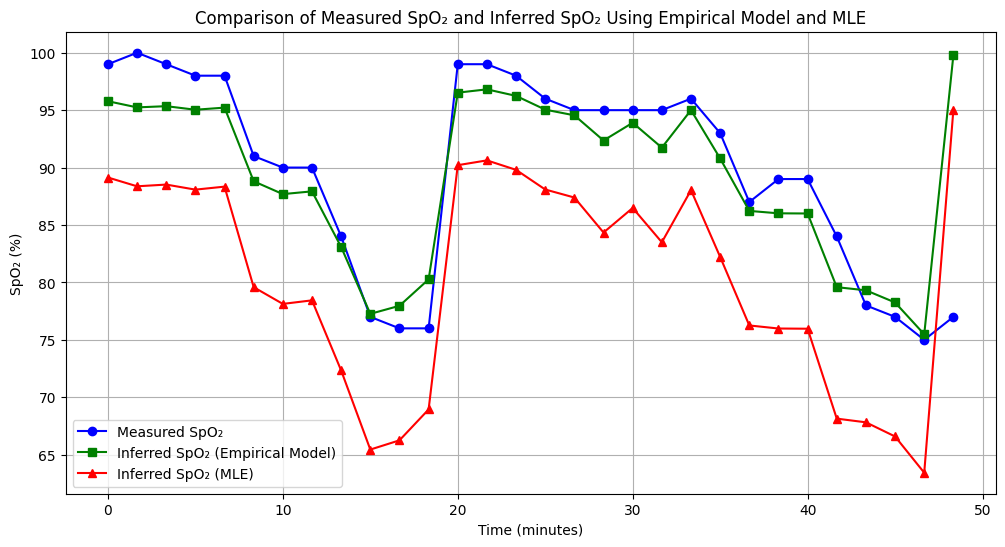

In [24]:
from scipy.optimize import minimize_scalar

SpO2_mle = []

for R_obs in R_subsampled:
    def objective(SpO2):
        SpO2_frac = SpO2 / 100  # 
        A_660 = SpO2_frac * eps_HbO2_660_fitted + (1 - SpO2_frac) * eps_Hb_660_fitted
        A_940 = SpO2_frac * eps_HbO2_940_fitted + (1 - SpO2_frac) * eps_Hb_940_fitted
        mu_R = A_660 / A_940  
        return (R_obs - mu_R)**2  

    res = minimize_scalar(objective, bounds=(0, 100), method='bounded')
    SpO2_mle.append(res.x)

SpO2_mle = np.array(SpO2_mle)

SpO2_empirical = 110 - 25 * R_subsampled

plt.figure(figsize=(12, 6))
plt.plot(t_subsampled, SpO2_subsampled, 'o-', label='Measured SpO₂', color='blue')
plt.plot(t_subsampled, SpO2_empirical, 's-', label='Inferred SpO₂ (Empirical Model)', color='green')
plt.plot(t_subsampled, SpO2_mle, '^-', label='Inferred SpO₂ (MLE)', color='red')
plt.xlabel('Time (minutes)')
plt.ylabel('SpO₂ (%)')
plt.title('Comparison of Measured SpO₂ and Inferred SpO₂ Using Empirical Model and MLE')
plt.legend()
plt.grid(True)
plt.show()


# Comparison of Measured and Predicted SpO₂ Values

In this plot, I compared the measured SpO2 values (blue) with predictions from two models: the empirical model (green) and the MLE-based model (red). Both models do a good job of capturing the overall trends in SpO2 especially during major changes over time.

- **Empirical Model (Green):**  
  The empirical model gives smoother predictions and handles noise well, but it occasionally drifts away from the measured values because of its simplified linear approach.

- **MLE-Based Model (Red):**  
  The MLE-based model tracks the measured Spo2 more closely in dynamic regions, but it’s a bit noisier. This is likely due to its sensitivity to fluctuations in \(R\)-ratios and the assumptions made during parameter estimation.

## Summary

- The **empirical model** is simpler and more robust to noise but trades off some precision.  
- The **MLE-based model** is more accurate but can be affected by data variability.  

Combining the strengths of both models could lead to even better predictions.
